In [1]:
import sympy
import numpy
import suncal

# Function Options

## Strings

String expressions can be entered, with basic functions (sin, cos, exp, log, etc.) recognized. The string must by "sympifyable". Note: powers can be entered using python syntax of `x**2` or carat syntax `x^2`.

In [2]:
# String
fstr = 'sqrt(a**2 + b**2)'

inputs = [{'name':'a', 'nom':24, 'uncerts':[{'std':.5}]},
          {'name':'b', 'nom':32, 'uncerts':[{'std':.5}]}]
u = suncal.UncertCalc(fstr, inputs=inputs)
u.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$f_{1}$   | GUM          | 40.00   | 0.50            | ± 0.98      | 1.960     | inf           |
|$f_{1}$   | Monte Carlo  | 40.00   | 0.50            | (39.02 , 40.98 ) | 1.959     | -             |

In [3]:
# String gets converted to sympy object internally.
u.model.expr_symbols

[Eq(f1, sqrt(a**2 + b**2))]

## Sympy Objects
A sympy expression can also be used as the input function. This allows more algebraic manipulation before using in the calculator.

In [4]:
a, b = sympy.symbols('a, b')
fsym = sympy.sqrt(a * b / sympy.pi)
fsym

sqrt(a*b)/sqrt(pi)

In [5]:
u = suncal.UncertCalc(fsym, inputs=inputs)
u.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$f_{1}$   | GUM          | 15.64   | 0.20            | ± 0.40      | 1.960     | inf           |
|$f_{1}$   | Monte Carlo  | 15.63   | 0.20            | (15.23 , 16.03 ) | 1.963     | -             |

## Python callables

Callable python functions may also be used. Function arguments must match input names defined in the calculator.
Function must return a float, or a tuple of floats.

In [6]:
def myfunc(a, b):
    return a * b + 10

u = suncal.UncertCalc(myfunc, inputs=inputs)
u.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$myfunc$   | GUM          | 778   | 20            | ± 39      | 1.960     | inf           |
|$myfunc$   | Monte Carlo  | 778   | 20            | (739 , 817 ) | 1.962     | -             |

If function returns a namedtuple, suncal can figure out the output names.

In [7]:
from collections import namedtuple

def myfunc(a, b):
    ret = namedtuple('MyFunc', ['abc', 'xyz'])
    return ret(a * b + 10, a-b)

u = suncal.UncertCalc(myfunc, inputs=inputs)
u.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$abc$   | GUM          | 778   | 20            | ± 39      | 1.960     | inf           |
|$abc$   | Monte Carlo  | 778   | 20            | (739 , 818 ) | 1.961     | -             |
|$xyz$   | GUM          | -8.00   | 0.71            | ± 1.4      | 1.960     | inf           |
|$xyz$   | Monte Carlo  | -8.00  | 0.71           | (-9.39 , -6.61 ) | 1.961     | -             |

And with multiple outputs, the correlation between output uncertianties is also computed

### Correlation Coefficients (GUM)


|-         | $abc$  | $xyz$ |
|---------|---------|---------|
|$abc$  | 1.000     | 0.141    |
|$xyz$  | 0.141     | 1.000    |

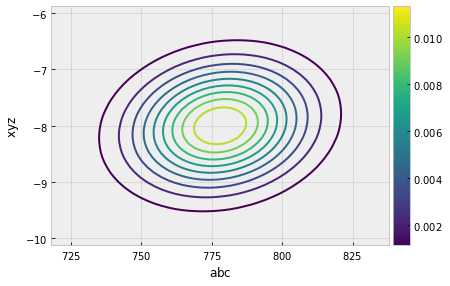

In [8]:
display(u.out.gum.report_correlation())
u.out.gum.plot_correlation();

### Callable with kwargs
Callables can also take variable keyword arguments (`**kwargs`) if the finnames parameter is specified. If the function cannot process Pint Quantity objects (values with units), and you would like to handle units on the inputs, the `finunits` and `foutunits` parameters can be specified, telling suncal what output units (`foutunits`) result when the input argements are in `finunits`. Notice the `UnitStrippedWarning` stating that units are ignored  in the myfunc2 function.

In [9]:
def myfunc2(**kwargs):
    X = numpy.array(list(kwargs.values()))
    return X.sum() / len(X)

data = {'X1':2, 'X2':4, 'X3':6, 'X4':8}

u = suncal.UncertCalc(myfunc2, finnames=data.keys(), samples=1000)  # Must specify names of keyword arguments
for i, xval in enumerate([2, 4, 6, 8]):
    u.set_input('X{}'.format(i+1), nom=xval, std=.2)
#    u.set_uncert('X{}'.format(i+1), std=.2)
    
u.calculate()

c:\users\cjdelke\miniconda3\envs\unc2\lib\site-packages\ipykernel_launcher.py:2: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  


|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$myfunc_{2}$   | GUM          | 5.00  | 0.10            | ± 0.20      | 1.960     | inf           |
|$myfunc_{2}$   | Monte Carlo  | 4997.355998   | 1.8e-12            | (4997.355998 , 4997.355998 ) | 0.000     | -             |

### More notes on python callable functions

- Monte Carlo calculation will be much faster if the callable function is vectorizable. If not, the calculator will resort to calling the function N times. (Note the reduced samples in the example above.)
- The gradients used in the GUM calculation will be solved numerically. Thus the derivation report will not be available for callable functions.
- Some callable functions won't work with Pint Quantities as inputs. For these, specify the `finunits` and `foutunits` arguments to UncertCalc. See Example_Inductance_Nagaoka.ipynb.

## Complex numbers

Functions involving complex numbers can be computed using `suncal.UncertComplex`, accounting for correlations between real and imaginary components. See Example_Voltage_Reflection_NIST1900_E15.ipynb for a more complete example.

In [10]:
u = suncal.UncertComplex(['x + y'], magphase=True, degrees=True)
u.set_input('x', .01, unc=.01+.01j, corr=.9)
u.set_input('y', .02-.01j, unc=.01+.01j, corr=.9)
u.calculate()

|Function   | Method       | Nominal        | Standard Uncertainty   | Correlation  |
|----------|------------|--------------|----------------------|-------------|
|f0         | GUM          | 0.0316  ∠-18°  | ± 0.0048  ∠16°         | 0.8554       |
|f0         | Monte Carlo  | 0.0329  ∠-20°  | ± 0.0047  ∠16°         | 0.7377       |

<AxesSubplot:xlabel='Re(f0)', ylabel='Im(f0)'>

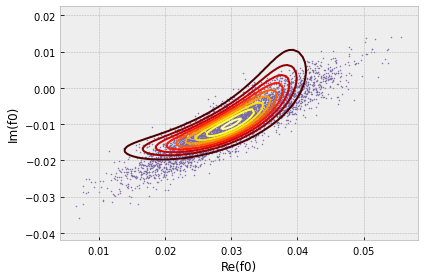

In [11]:
u.out.plot(polar=False, showgum=True, showmc=True, gumcontour=True)

In [12]:
# UncertComplex splits the function into its components and solves them individually
u.out.fullout.gum.report_func()

$f_{0 mag} = \sqrt{\left(x_{\left|{i}\right|} + y_{\left|{i}\right|}\right)^{2} + \left(x_{real} + y_{real}\right)^{2}}$

$f_{0 rad} = \operatorname{atan_{2}}{\left(x_{\left|{i}\right|} + y_{\left|{i}\right|},x_{real} + y_{real} \right)}$